<a href="https://colab.research.google.com/github/kw01sg/neural-style-transfer/blob/master/google_colab_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Clone and Install Dependencies

In [0]:
!git clone https://github.com/kw01sg/neural-style-transfer.git

In [0]:
%cd neural-style-transfer

In [0]:
!pip install tensorflow-gpu==2.0.0-beta1

## Demo

In [5]:
!python neural_transfer.py --help

usage: neural_transfer.py [-h] [-c CONTENT_PATH] [-s STYLE_PATH]
                          [-cw CONTENT_WEIGHT] [-sw STYLE_WEIGHT]
                          [-vw VARIATION_WEIGHT]
                          [-slw STYLE_LAYER_WEIGHTS STYLE_LAYER_WEIGHTS STYLE_LAYER_WEIGHTS STYLE_LAYER_WEIGHTS STYLE_LAYER_WEIGHTS]
                          [-wn] [-lr LEARNING_RATE] [-e EPOCHS]
                          [-steps STEPS_PER_EPOCH] [-o OUTPUT_FILE]

Perform neural style transfer.

optional arguments:
  -h, --help            show this help message and exit
  -c CONTENT_PATH, --content-path CONTENT_PATH
                        path of content image
  -s STYLE_PATH, --style-path STYLE_PATH
                        path of style image
  -cw CONTENT_WEIGHT, --content-weight CONTENT_WEIGHT
                        content weight
  -sw STYLE_WEIGHT, --style-weight STYLE_WEIGHT
                        style weight
  -vw VARIATION_WEIGHT, --variation-weight VARIATION_WEIGHT
                        variat

In [6]:
!python neural_transfer.py

Running neural style transfer with the following parameters:

	content_path: data/demo/chicago.jpg
	style_path: data/demo/candy.jpg
	content_weight: 0.4
	style_weight: 1.0
	variation_weight: 20000.0
	style_layer_weights: [1.0, 1.0, 1.0, 1.0, 1.0]
	white_noise_input: False
	learning_rate: 10.0
	epochs: 10
	steps_per_epoch: 100
	output_file: result.png

574717952/574710816 [==============================] - 88s 0us/step
W0713 17:07:56.619529 140228320671616 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1205: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/10
100/100 [==================================================] - 12s - 116ms/step
Epoch 2/10
100/100 [==================================================] - 7s - 73ms/step
Epoch 3/10
100/100 [=========

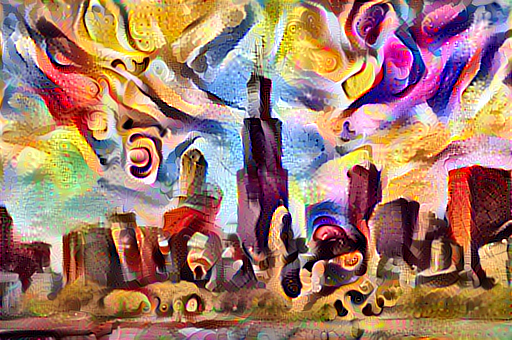

In [7]:
from PIL import Image

Image.open('/content/neural-style-transfer/data/results/result.png')

## Hands On

In [0]:
from google.colab import files

In [0]:
# upload your content image file
files.upload()

In [0]:
# upload your style image file
files.upload()

In [0]:
!python neural_transfer.py -c {path to content image} -s {path to style image}

In [0]:
from PIL import Image

Image.open('/content/neural-style-transfer/data/results/result.png')